In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
import skimage

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import torchvision.datasets as datasets
from torchvision.transforms.functional import to_pil_image

In [5]:
#class to threshold images
class Threshold(object):
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, image):
        img_array = np.array(image)
        img_array[img_array <= self.threshold] = 0
        img_array[img_array > self.threshold] = 255

        #convert back to pillow
        thresholded_img = Image.fromarray(img_array)

        return thresholded_img

In [6]:
#transforming the dataset to be used
transform = transforms.Compose([
    transforms.Resize((64,64),antialias=True),
    Threshold(threshold=20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [7]:
#function to create your own custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = self._get_image_files()

    def _get_image_files(self):
        files = os.listdir(self.root_dir)
        image_files = [file for file in files if file.endswith(('10.jpg'))]
        return image_files

    def __len__(self):
        return len(self.image_files)

    def _get_labels(self):
        labels = [1] * len(self.image_files) #label ones for true images
        return labels

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)
        labels = [1] * len(self.image_files)
        if self.transform:
            image = self.transform(image)

        label = labels[idx]
        return image, label

In [8]:
# dataset = CustomDataset(root_dir="/content/drive/MyDrive/HCS Project/HCS data", transform=transform)

In [9]:
dataset = CustomDataset(root_dir="/content/drive/MyDrive/HCS Project/archive.zip (Unzipped Files)/data/data", transform=transform)

In [10]:
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

In [11]:
len(dataset)

1000

In [ ]:
plt.imshow(to_pil_image(dataset[1][0]),cmap = 'gray')

In [ ]:
print(dataset[0])

##Model

In [17]:
#this function initializes a set of weights around the number zero
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)  # Normal distribution (mean=0, std=0.02)

In [18]:
batch_size = 50
num_epochs = 25
learning_rate = 0.00025
latent_dim = 256

In [19]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            # Input: Noise vector
            self.deconv_block(latent_dim, 256, 4, 1, 0),  # Start from a smaller image
            self.deconv_block(256, 256, 4, 2, 1),
            self.deconv_block(256, 128, 4, 2, 1),
            self.deconv_block(128, 128, 4, 2, 1),
            # Output:
            nn.ConvTranspose2d(128, 1, 4, 2, 1),
            nn.Tanh()

        )

    def deconv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.model(x)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input:
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            self.conv_block(128, 128, 4, 2, 1),
            self.conv_block(128, 256, 4, 2, 1),
            self.conv_block(256, 512, 4, 2, 1),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

# Initialize generator, discriminator, and apply weight initialization
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
initialize_weights(generator)
initialize_weights(discriminator)

In [20]:
# Loss and optimizers
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss - suitable for GANs
# The weights are optimized via adaptive momentum
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [ ]:
# TensorBoard setup for visualization
writer = SummaryWriter("runs/dcgan_mnist")

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)

        # Train discriminator with real images
        discriminator.zero_grad()
        real_labels = torch.ones(images.size(0), 1).to(device)
        output = discriminator(images).view(-1)
        loss_d_real = criterion(output, real_labels.squeeze(1))
        loss_d_real.backward()

        # Train discriminator with fake images
        noise = torch.randn(images.size(0), latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(images.size(0), 1).to(device)
        output = discriminator(fake_images.detach()).view(-1)  # detach to avoid backprop through G
        loss_d_fake = criterion(output, fake_labels.squeeze(1))
        loss_d_fake.backward()
        loss_d = loss_d_real + loss_d_fake
        optimizer_d.step()

        # Train generator
        generator.zero_grad()
        output = discriminator(fake_images).view(-1)
        loss_g = criterion(output, real_labels.squeeze(1))  # Aim to fool the discriminator
        loss_g.backward()
        optimizer_g.step()

        # Logging and visualization
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} \
                  Loss D: {loss_d:.4f}, Loss G: {loss_g:.4f}")

            with torch.no_grad():
                fake_images = generator(noise)
                img_grid = torchvision.utils.make_grid(fake_images, normalize=True)
                writer.add_image('Generated Images', img_grid, global_step=epoch * len(dataloader) + i)

# Close TensorBoard writer when done
writer.close()

Epoch [0/25] Batch 0/20                   Loss D: 1.4058, Loss G: 0.7742
Epoch [1/25] Batch 0/20                   Loss D: 0.4028, Loss G: 1.8846
Epoch [2/25] Batch 0/20                   Loss D: 0.2245, Loss G: 2.5786
Epoch [3/25] Batch 0/20                   Loss D: 0.0814, Loss G: 3.4939
Epoch [4/25] Batch 0/20                   Loss D: 0.0597, Loss G: 3.8532
Epoch [5/25] Batch 0/20                   Loss D: 0.0225, Loss G: 4.5550
Epoch [6/25] Batch 0/20                   Loss D: 3.5653, Loss G: 0.2867
Epoch [7/25] Batch 0/20                   Loss D: 0.6129, Loss G: 2.1982
Epoch [8/25] Batch 0/20                   Loss D: 0.2347, Loss G: 3.7370
Epoch [9/25] Batch 0/20                   Loss D: 0.1100, Loss G: 5.1429
Epoch [10/25] Batch 0/20                   Loss D: 0.0528, Loss G: 5.1894
Epoch [11/25] Batch 0/20                   Loss D: 0.0622, Loss G: 4.9769
Epoch [12/25] Batch 0/20                   Loss D: 0.2659, Loss G: 3.2204


In [ ]:
#in case you need to filter your own image
from skimage.filters import threshold_otsu
from skimage import color

In [ ]:
from google.colab import files
files = files.upload()

Saving Screenshot (97).png to Screenshot (97).png


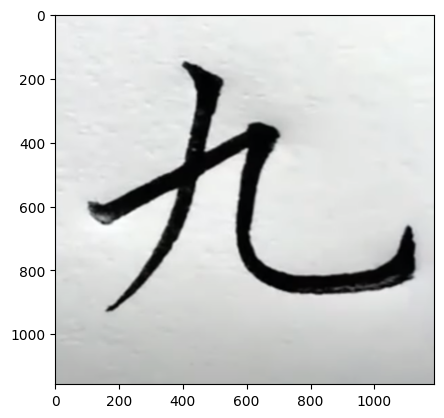

In [ ]:
#base image
b = cv2.imread('Screenshot (97).png')
plt.imshow(b)

In [ ]:
#convert to grayscale
b = b[:,:,:3]
b = color.rgb2gray(b)

<ipython-input-10-7be753be2d45>:1: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1157, 1188, 3) looks like that of an RGB image.
  thresh = threshold_otsu(b)


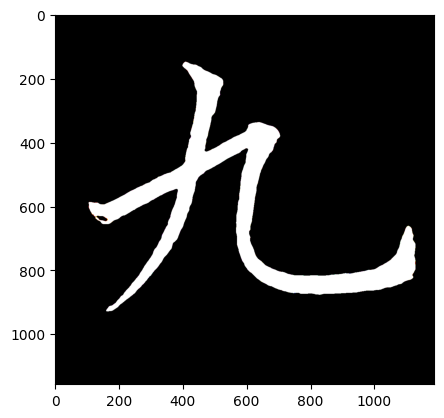

In [ ]:
#threshold if needed
thresh = threshold_otsu(b)
binary = thresh> b
binary = binary * 255
plt.imshow(binary, cmap = 'gray')

In [ ]:
#convert to a tensor
binary = torch.tensor(b)
binary.size()

torch.Size([1157, 1188, 3])

In [ ]:
import torch.nn.functional as F
#resize the image to one that is fitted for the GAN
resized_binary = F.interpolate(binary.unsqueeze(0).unsqueeze(0).float(), size=(64, 64), mode='nearest')
b_image1 = resized_binary.squeeze(0).squeeze(0)

b_image2 = transform(to_pil_image(b_image1))
b_image6 = b_image2.repeat(1, latent_dim, 1, 1)
b_image = b_image6.to(device)

In [ ]:
#should be 64,128,1,1

In [ ]:
b_image.size()

In [ ]:
#last preprocessing
b_image = b_image.permute(2, 1, 0, 3)
b_image_reshaped = b_image[:, :, :, :1]

print(b_image_reshaped.size())

In [ ]:
#generate noise vector to be used by the gan
noise = torch.randn(64, latent_dim, 1, 1, device=device)
print(noise.size())


In [ ]:
#combine noise vector and input
input = noise+b_image_reshaped

In [ ]:
input.size()

In [ ]:
with torch.no_grad():
    generated_images = generator(noise+b_image_reshaped)
    img_grid = torchvision.utils.make_grid(generated_images,normalize=True)

In [ ]:
plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())
plt.show()